Code for testing and developing the BumpFcn Module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import generate_hypergrid_pts
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.ml.wandering_modules import BumpFcn

## Parameters go here

In [3]:
n_dims = 6
n_smps = 100000

## Helper functions go here

In [4]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100, dims=[0, 1], fixed_values=None):
    
    pts = generate_hypergrid_pts(d = 2, n_smps_per_dim=n_smps_per_dim)

    if fixed_values is None:
        full_pts = np.zeros([pts.shape[0], n_dims])
    else:
        full_pts = np.tile(np.expand_dims(fixed_values, 1), pts.shape[0]).transpose()
    
    
    full_pts[:, dims[0]] = pts[:,0]
    full_pts[:, dims[1]] = pts[:, 1]
    
    y_grid = f(full_pts).reshape([n_smps_per_dim, n_smps_per_dim])
    plt.imshow(y_grid)
    plt.colorbar()

In [5]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None,
        update_int=100):

    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.pert_grads()
        optimizer.step()
        nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
            print('ctr: ' + str(nn.c))
            print('w: ' + str(nn.w))
            print('m: ' + str(nn.m))

## Create a ground truth bump function and data

In [25]:
true_bf = BumpFcn(c=.2*torch.ones(n_dims), w=.3*torch.ones(n_dims), m=-1, support_p = .0000000001)

x = torch.rand([n_smps, n_dims])
with torch.no_grad():
    y = true_bf(x)

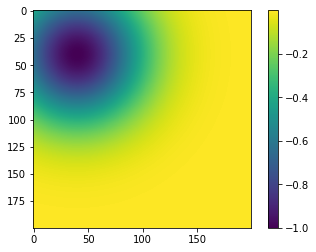

In [26]:
plot_2d_f(torch_mod_to_fcn(true_bf), n_smps_per_dim=200, dims = [0, 1], fixed_values = .2*np.ones([n_dims]))

## Fit a bump function to the data

In [53]:
c_bounds = torch.stack((torch.zeros(n_dims), torch.ones(n_dims)))

In [54]:
fit_bf = BumpFcn(c= .9*torch.ones(n_dims), w=10*torch.ones(n_dims), m=0, 
                 c_bounds=torch.stack((torch.zeros(n_dims), torch.ones(n_dims))),
                 w_bounds=torch.stack((.1*torch.ones(n_dims), 10*torch.ones(n_dims))),
                 c_grad_std =0, w_grad_std=0, m_grad_gain=0, support_p=.00001)

In [55]:
for i in range(1):
    fit(nn=fit_bf, x=x, y=y, lr=.01, n_its=1001, batch_size=10000, update_int=500)

It 0: 1.516009e-03
ctr: Parameter containing:
tensor([0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000], requires_grad=True)
w: Parameter containing:
tensor([10., 10., 10., 10., 10., 10.], requires_grad=True)
m: Parameter containing:
tensor([-0.0100], requires_grad=True)
It 500: 1.684246e-03
ctr: Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)
w: Parameter containing:
tensor([2.7748, 2.7991, 2.8134, 2.8044, 2.7969, 2.8272], requires_grad=True)
m: Parameter containing:
tensor([-0.0110], requires_grad=True)
It 1000: 3.590206e-07
ctr: Parameter containing:
tensor([0.1995, 0.1985, 0.1993, 0.1985, 0.1989, 0.2004], requires_grad=True)
w: Parameter containing:
tensor([0.3026, 0.3035, 0.3021, 0.3044, 0.3040, 0.3023], requires_grad=True)
m: Parameter containing:
tensor([-0.9703], requires_grad=True)


## Look at the fit in different z planes

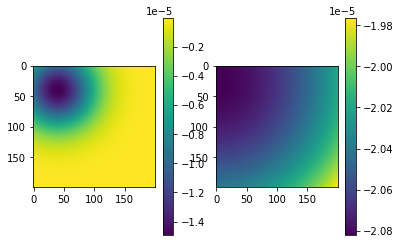

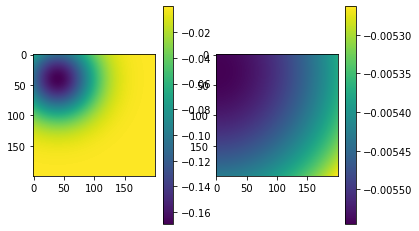

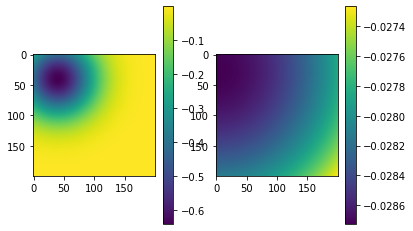

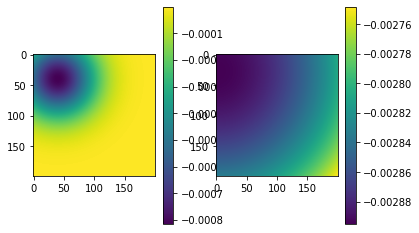

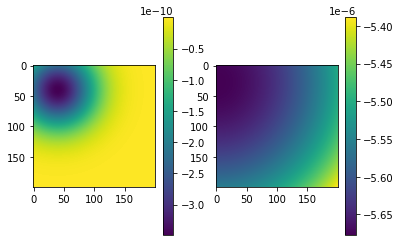

In [47]:
z_values = np.arange(-.3, 1, .3)
for z_v in z_values:
    plt.figure()
    plt.subplot(1,2,1)
    plot_2d_f(torch_mod_to_fcn(true_bf), n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))
    plt.subplot(1,2,2)
    plot_2d_f(torch_mod_to_fcn(fit_bf), n_smps_per_dim=200, dims = [0, 1], fixed_values = z_v*np.ones(n_dims))